In [3]:
import pandas as pd
import os
import numpy as np

matchedDataFileName = "data/matchedData_300_0.3.pkl"
matchedData = pd.read_pickle(matchedDataFileName)

validationDataFileName = "data/validationData_100_0.3.pkl"
validationData = pd.read_pickle(validationDataFileName)


dataFolder = "data/compressedSignalsAdjusted/"
dataFiles = os.listdir(dataFolder)

# Read in all numpy arrays
data = []
fileNames = []
for file in dataFiles:
    data.append(np.load(dataFolder + file))
    fileNames.append(file)

display(matchedData)

,filename1,filename2,label1,label2,match
0,fseivkaego.wav,ooyevtcxvf.wav,2,6,False
1,tkaorzfyzc.wav,pxtgqsabnh.wav,1,9,False
2,zviuujuuou.wav,afceoescqs.wav,4,6,False
3,oagvqxyqxz.wav,xmclwscjcz.wav,1,7,False
4,tkaorzfyzc.wav,nvdmllxvqy.wav,1,7,False
...,...,...,...,...,...
995,zviuujuuou.wav,xwrxxvztrb.wav,4,6,False
996,ztvloagxul.wav,afceoescqs.wav,2,6,False
997,zviuujuuou.wav,tsoxcpgasb.wav,4,9,False
998,ooyevtcxvf.wav,cgxwaehnir.wav,6,3,False


In [4]:
def replaceFileNameWithArray(fileName):
    fileName = fileName.replace(".wav", ".npy")
    indexOfFile = fileNames.index(fileName)
    return data[indexOfFile]

matchedData["signal1"] = matchedData["filename1"].apply(replaceFileNameWithArray)
matchedData["signal2"] = matchedData["filename2"].apply(replaceFileNameWithArray)

validationData["signal1"] = validationData["filename1"].apply(replaceFileNameWithArray)
validationData["signal2"] = validationData["filename2"].apply(replaceFileNameWithArray)

In [5]:
print(len(matchedData["signal1"][0]))

5120


In [24]:
# Train a nueral network to take signal1 and signal1 and predict if they are a match
# Use the matchedData dataframe to train the network
# Make a autoencoder model to compress the audio signal
from tensorflow.keras.layers import Input, Dense

# Input shape is len(signal1) + len(signal2)

# Input layer
input_layer = Input(shape=(len(matchedData["signal1"][0]) + len(matchedData["signal2"][0]),))

# Add 5 hidden layers with 500 100 50 10 5 nodes
hidden_layer1 = Dense(500, activation='tanh')(input_layer)
hidden_layer2 = Dense(100, activation='tanh')(hidden_layer1)
hidden_layer3 = Dense(50, activation='tanh')(hidden_layer2)
hidden_layer4 = Dense(10, activation='relu')(hidden_layer3)
hidden_layer5 = Dense(5, activation='relu')(hidden_layer4)

# Output layer
output_layer = Dense(1, activation='sigmoid')(hidden_layer5)

# Create the model
from tensorflow.keras.models import Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint_name = "modelCheckpoints/Weights-matchmodel1-{epoch:03d}--{val_loss:.5f}.hdf5"
# checkpoint = ModelCheckpoint(checkpoint_name, monitor="val_loss", verbose=1, save_best_only=True, mode="auto")
# callbacks_list = [checkpoint]
signals = []
for i in range(len(matchedData)):
    signals.append(np.concatenate((matchedData["signal1"][i], matchedData["signal2"][i])))

ys = []
for i in range(len(matchedData)):
    ys.append([matchedData["match"][i]])

# Train the model
model.fit(x = np.array(signals), y = np.array(ys), epochs=50, batch_size=8, validation_split=0.2)






Epoch 1/50
100/100 [==============================] - 1s 10ms/step - loss: 0.6304 - accuracy: 0.6975 - val_loss: 0.5990 - val_accuracy: 0.7100
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6131 - accuracy: 0.7013 - val_loss: 0.5858 - val_accuracy: 0.7100
Epoch 3/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5751 - accuracy: 0.7200 - val_loss: 0.5498 - val_accuracy: 0.7250
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - loss: 0.4902 - accuracy: 0.7688 - val_loss: 0.3838 - val_accuracy: 0.8350
Epoch 5/50
100/100 [==============================] - 1s 10ms/step - loss: 0.3616 - accuracy: 0.8350 - val_loss: 0.2630 - val_accuracy: 0.9150
Epoch 6/50
100/100 [==============================] - 1s 10ms/step - loss: 0.2359 - accuracy: 0.8875 - val_loss: 0.2069 - val_accuracy: 0.9200
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2091 - accuracy: 0.9075 - val_loss: 0.2064 - val_accuracy: 0.9000
Epo

32/32 [==============================] - 0s 4ms/step


Predicted,0,1
Actual,,
0,700,0
1,0,300


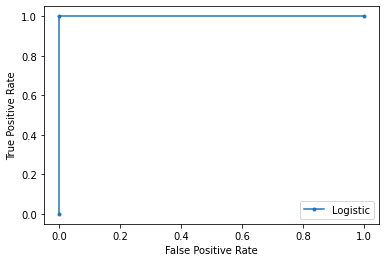

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       700
        True       1.00      1.00      1.00       300

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [25]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix

predictions = model.predict(np.array(signals))
predictions = [1 if x > 0.5 else 0 for x in predictions]

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(ys, predictions)
df_cm = pd.DataFrame(array, index = [i for i in "01"],
                    columns = [i for i in "01"])
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
display(df_cm)

# print roc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# calculate roc curves
fpr, tpr, thresholds = roc_curve(ys, predictions)
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


# Print classification report
from sklearn.metrics import classification_report
print(classification_report(ys, predictions))

In [26]:
validYs = []
for i in range(len(validationData)):
    validYs.append([validationData["match"][i]])

validSignals = []
for i in range(len(validationData)):
    validSignals.append(np.concatenate((validationData["signal1"][i], validationData["signal2"][i])))

validPredictions = model.predict(np.array(validSignals))
validPredictions = [1 if x > 0.85 else 0 for x in validPredictions]

array = confusion_matrix(validYs, validPredictions)
df_cm = pd.DataFrame(array, index = [i for i in "01"],
                    columns = [i for i in "01"])
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
display(df_cm)

print(classification_report(validYs, validPredictions))


4/4 [==============================] - 0s 4ms/step


Predicted,0,1
Actual,,
0,70,0
1,0,30


              precision    recall  f1-score   support

       False       1.00      1.00      1.00        70
        True       1.00      1.00      1.00        30

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [27]:
# Save the model hdf5 file
model.save("modelCheckpoints/classificationModel.h5")